In [1]:
import os
import sys
sys.path.append('../libraries/') # Append the path within which the user-defined class is in
from data_loader import data_loader
from behavior_loader import bsoid_loader

import joblib
from joblib import Parallel, delayed
import time
import pickle

import autograd.numpy as np
import autograd.numpy.random as npr
npr.seed(0)

from hmmlearn import hmm
import matplotlib.pyplot as plt
import numpy as np
from tkinter import *
from tkinter.filedialog import askopenfilename, askdirectory
from tqdm import tqdm
import scipy.stats as stats

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("white")
sns.set_context("talk")

import ssm
from ssm.util import find_permutation
from ssm.plots import gradient_cmap, white_to_color_cmap

## functions to load neural data

In [2]:
data_dir = r'../processed_data'
file_name = r'm1_fr0.1hz_30hz_0s_7200s_0.1s_bins_nooverlap.sav'
d_l = data_loader(data_dir, file_name)
data = d_l.load_data()

Spike times are binned into shape for hmm: (36000, 46)


## functions to load behavior

In [3]:
file_name = r'ag25290_day2_iter13'
# Load behaviors
behavior_loader = bsoid_loader(data_dir, file_name)
f_index, filtered_data, smoothed_predictions = behavior_loader.main()

mouse stayed in nest for 0.28108749470484795% of time
File #0 (a 6 body parts by 984391 frames) has 30 classes


In [4]:
# Correct prediction start
framerate = 60
delay = 6.8503
behavior_start = int(delay * framerate)  # start of behavior
smoothed_predictions_1h = smoothed_predictions[behavior_start:(behavior_start+3600*60)]

In [8]:
K = 16

In [9]:
model_dir = "../hmm_models/"

In [10]:
# Load merged model
hmm_mrg = pickle.load(open(os.path.join(model_dir, f"1h_l5_possion_merged_{K}_latents" + ".hmm"), "rb"))
print(f'1h_l5_possion_merged_{K}_latents.hmm loaded.')

1h_l5_possion_merged_16_latents.hmm loaded.


In [11]:
hmm_mrg.score(data)

537309.4751941374

In [74]:
# Load model
hmm_dir = pickle.load(open(os.path.join(model_dir, f"1h_l5_possion_direct_{K}_latents" + ".hmm"), "rb"))
print(f'1h_l5_possion_direct_{K}_latents.hmm loaded.')

1h_l5_possion_direct_150_latents.hmm loaded.


In [75]:
hmm_dir.score(data)

877671.2286170352

## behavior names

In [ ]:
names = ['torso groom', 'investigate type 0', 'unsure', 'wall rear type 1', 'rear',
         'unsure', 'wall rear type 2', 'investigate type 1', 'investigate type 2', 'contra-itch',
         'investigate type 3', 'sleep/scrunch type 1', 'sleep/scrunch type 2', 'wall rear type 3', 'contra-body groom',
         'face groom type 1', 'dive/scrunch', 'head groom', 'ipsi-orient', 'ipsi-investigate',
         'face groom type 2', 'ipsi-body groom', 'ipsi-itch type 1', 'ipsi-itch type 2', 'face groom type 3', 
         'paw groom', 'locomotion', 'contra-forepaw orient', 'contra-orient']

In [12]:
names_mod = ['insignificant', 'insignificant', 'insignificant', 'insignificant', 'rear',
         'insignificant', 'insignificant', 'investigate type 1', 'investigate type 2', 'contra-itch',
         'investigate type 3', 'insignificant', 'insignificant', 'insignificant', 'contra-body groom',
         'face groom type 1', 'dive/scrunch', 'head groom', 'ipsi-orient', 'insignificant',
         'face groom type 2', 'ipsi-body groom', 'ipsi-itch type 1', 'insignificant', 'insignificant', 
         'paw groom', 'locomotion', 'insignificant', 'contra-orient']

## associate each hmm state to the behavior appearing the most during this state

In [13]:
def hmm_state_to_behavior(hmm_model, data, behavior_predictions, lead_seconds, lag_seconds, framerate, hmm_samplerate, names):
    print(50*'=')
    print(f'A {hmm_model.n_components}-state hmm is used to match with behaviors.')
    print(50*'-')
    
    def most_freq_behav_idx(uniq_behavs, uniq_behavs_cnts):
        uniq_behavs_indcs = np.argsort(-uniq_behavs_cnts)  
        for uniq_behavs_indc in uniq_behavs_indcs:
            idt_behav = int(uniq_behavs[uniq_behavs_indc])
            if names[idt_behav] != 'insignificant':
                return idt_behav
        return -1
    
    end_behav_idx = len(behavior_predictions)
    hmm_states = hmm_model.predict(data)
    
    idt_behav_for_states = np.ones(len(np.unique(hmm_states)))
    idt_behav_for_states_names = []
    for i, hmm_state in enumerate(np.unique(hmm_states)):
        state_idcs = np.where(hmm_states == hmm_state)[0]
        behav_idcs = state_idcs * int(framerate/hmm_samplerate)
        idt_behavs_list = [] # identified behaviors list
        for behav_idx in behav_idcs:
            # Start index is 100ms ahead on-site
            start_idx = behav_idx - int(framerate/hmm_samplerate * (lead_seconds/0.1))
            if start_idx < 0:
                start_idx = 0
            # End index is 300ms behind on-site
            end_idx = behav_idx + int(framerate/hmm_samplerate * (lag_seconds/0.1))
            if end_idx > end_behav_idx:
                end_idx = end_behav_idx
            # Access identified behaviors using behavior indices
            behav_idcs_rng = np.arange(start_idx, end_idx)
            behavs = behavior_predictions[behav_idcs_rng]
            uniq_behavs, uniq_behavs_cnts = np.unique(behavs, return_counts=True)
            # Winner takes all
            idt_behav = most_freq_behav_idx(uniq_behavs, uniq_behavs_cnts)
            if idt_behav != -1:
                idt_behavs_list.append(idt_behav)
        idt_behavs = np.array(idt_behavs_list)  
        uniq_idt_behavs, uniq_idt_behavs_cnts = np.unique(idt_behavs, return_counts=True)
        idt_behav_for_states[i] = most_freq_behav_idx(uniq_idt_behavs, uniq_idt_behavs_cnts)
        idt_behav_for_states_names.append(names[int(idt_behav_for_states[i])])
        idt_behav_for_states = idt_behav_for_states.astype(int)
    print('Identified behaviors are: ' + str(idt_behav_for_states_names))
    print(50*'-')
    print(f'{len(np.unique(idt_behav_for_states))} unique behaviors identified.')
    print(50*'-')
    uniq_idt_behav_for_states, uniq_idt_behav_for_states_cnts = np.unique(idt_behav_for_states, return_counts=True)
    uniq_idt_behavs_for_states_indcs = np.argsort(-uniq_idt_behav_for_states_cnts)
    for uniq_idt_behavs_for_states_indc in uniq_idt_behavs_for_states_indcs:
        print(names[int(uniq_idt_behav_for_states[int(uniq_idt_behavs_for_states_indc)])] + f': {int(uniq_idt_behav_for_states_cnts[uniq_idt_behavs_for_states_indc])}')
    print(50*'=')

## behaviors identified by a merged hmm

In [14]:
hmm_state_to_behavior(hmm_model=hmm_mrg, 
                      data=data, 
                      behavior_predictions=smoothed_predictions_1h, 
                      framerate=60, 
                      hmm_samplerate=10,
                      lead_seconds=0.1,
                      lag_seconds=0.3,
                      names=names_mod) # Can use either names or names_mod as input behaviors

A 16-state hmm is used to match with behaviors.
--------------------------------------------------
Identified behaviors are: ['locomotion', 'locomotion', 'locomotion', 'locomotion', 'face groom type 1', 'investigate type 2', 'investigate type 2', 'contra-itch', 'contra-body groom', 'face groom type 1', 'locomotion', 'locomotion', 'investigate type 2', 'locomotion', 'investigate type 2', 'investigate type 2']
--------------------------------------------------
5 unique behaviors identified.
--------------------------------------------------
locomotion: 7
investigate type 2: 5
face groom type 1: 2
contra-itch: 1
contra-body groom: 1


## behaviors identified by a direct hmm

In [78]:
hmm_state_to_behavior(hmm_model=hmm_dir, 
                      data=data, 
                      behavior_predictions=smoothed_predictions_1h, 
                      framerate=60, 
                      hmm_samplerate=10,
                      lead_seconds=0.1,
                      lag_seconds=0.3,
                      names=names_mod) # Can use either names or names_mod as input behaviors

A 150-state hmm is used to match with behaviors.
--------------------------------------------------
Identified behaviors are: ['ipsi-itch type 1', 'investigate type 2', 'face groom type 1', 'investigate type 2', 'face groom type 1', 'investigate type 2', 'face groom type 1', 'investigate type 2', 'ipsi-body groom', 'contra-itch', 'face groom type 1', 'investigate type 2', 'investigate type 2', 'investigate type 2', 'locomotion', 'face groom type 1', 'investigate type 2', 'locomotion', 'head groom', 'ipsi-body groom', 'face groom type 1', 'investigate type 2', 'investigate type 2', 'investigate type 2', 'investigate type 2', 'ipsi-body groom', 'investigate type 2', 'face groom type 1', 'investigate type 2', 'contra-body groom', 'ipsi-body groom', 'ipsi-body groom', 'investigate type 2', 'ipsi-body groom', 'contra-body groom', 'contra-body groom', 'ipsi-body groom', 'investigate type 2', 'head groom', 'investigate type 2', 'face groom type 1', 'contra-body groom', 'contra-itch', 'investi

## composition of hmm states in an identified behavior

In [69]:
def behavior_to_hmm_state_plot(behav_id, names, data, hmm_model, behavior_predictions, framerate, hmm_samplerate, save_figures):
    non_behav_idcs_raw = np.where(behavior_predictions != behav_id)[0]
    non_behav_idcs = np.unique((non_behav_idcs_raw / (framerate/hmm_samplerate)).astype(int))
    
    behav_idcs_raw = np.where(behavior_predictions == behav_id)[0]
    behav_idcs = np.unique((behav_idcs_raw / (framerate/hmm_samplerate)).astype(int))
    
    hmm_states = hmm_model.predict(data)
    
    K = hmm_model.n_components
    print(f'{len(np.unique(hmm_states[behav_idcs]))} states in a {K}-hmm have occurred during ' + names[behav_id] + '.')
    
    behav_states = hmm_states.copy()
    behav_states[non_behav_idcs] = K
    
    s = sns.color_palette('RdPu', K+1)
    s[K] = (1, 1, 1)
    cmap = gradient_cmap(s)
    
    plt.figure(figsize=(8, 4))
    plt.title('hmm states activated during ' + names[behav_id], fontsize=17)
    plt.xlim(0, 600)
    plt.xticks(np.arange(0, 36001, step=6000), np.arange(0, 3601, step=600)) #(Locations, labels)
    plt.ylabel("$z_{\\mathrm{inferred}}$")
    plt.yticks([])
    plt.xlabel('time(s)', fontsize=17)
    plt.tight_layout()
    plt.imshow(behav_states[None, :36000], aspect="auto", cmap=cmap)
    
    if save_figures:
        plt.savefig(f'../plots/{K}_hmm_l5_100ms_' + names[behav_id] + '.png')

48 states in a 50-hmm have occurred during investigate type 2.


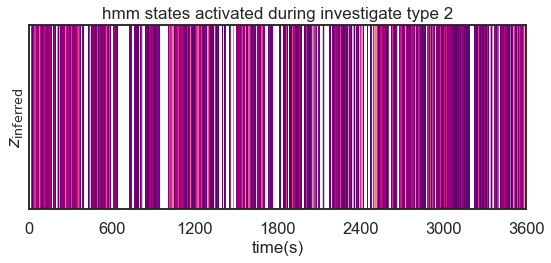

In [70]:
behavior_to_hmm_state_plot(behav_id=8, 
                           names=names_mod, 
                           data=data, 
                           hmm_model=hmm_dir, 
                           behavior_predictions=smoothed_predictions_1h, 
                           framerate=60, 
                           hmm_samplerate=10,
                           save_figures=True)

48 states in a 50-hmm have occurred during locomotion.


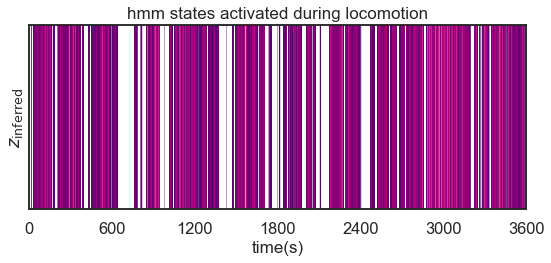

In [71]:
behavior_to_hmm_state_plot(behav_id=26, 
                           names=names_mod, 
                           data=data, 
                           hmm_model=hmm_dir, 
                           behavior_predictions=smoothed_predictions_1h, 
                           framerate=60, 
                           hmm_samplerate=10,
                           save_figures=True)

47 states in a 50-hmm have occurred during face groom type 1.


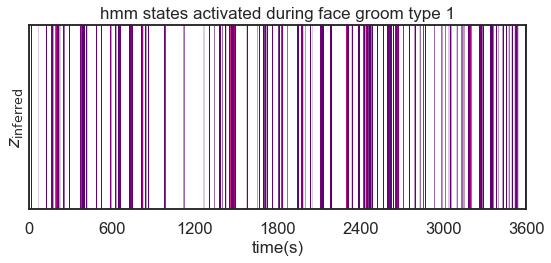

In [72]:
behavior_to_hmm_state_plot(behav_id=15, 
                           names=names_mod, 
                           data=data, 
                           hmm_model=hmm_dir, 
                           behavior_predictions=smoothed_predictions_1h, 
                           framerate=60, 
                           hmm_samplerate=10,
                           save_figures=True)